In [24]:
import os
import pandas as pd
from configparser import ConfigParser

cfg = ConfigParser()
cfg.read('../config.ini')
imgs_dir = cfg.get('dirs', 'img_tiles')
fetex_dir = cfg.get('dirs','fetex')
accidents_dir = cfg.get('dirs', 'accidentes')
metrics_dir = cfg.get('dirs', 'road_metrics')
grid_id = cfg.get('grid', 'default')
print(f'using {grid_id}')

using m250


1\. Read the labels file created

In [25]:
train = pd.read_csv(f'../support_data/{grid_id}/train.csv')
test = pd.read_csv(f'../support_data/{grid_id}/test.csv')

2\. Using that split we create both image and metric splits

- Images split

- Csv data split

In [26]:
def clean_up_columns(data):
    data.columns = map(str.lower, data.columns)
    data.columns = map(str.strip, data.columns)
    if 'geometry' in data.columns:
        data.drop('geometry', axis=1, inplace=True)
    if 'processed' in data.columns:
        data.drop('processed', axis=1, inplace=True)
    if 'sample' in data.columns:
        data.drop('sample', axis=1, inplace=True)
    data = data.dropna()
    return data

def join_dataframes(*multiple_df):
    output = []
    for df in multiple_df:
        if len(output):
            output = df.join(output)
        else:
            output = df
    print(output.dropna().shape)
    return output.dropna()       


# Load Accidents
accidents = pd.read_csv(f'{accidents_dir}/{grid_id}_c.csv')
accidents = clean_up_columns(accidents) 
accidents.set_index('id', inplace=True)

# Load Fetex
fetex = pd.read_csv(f'{fetex_dir}/r_fetex_{grid_id}.txt')
fetex = clean_up_columns(fetex)
fetex.set_index('id', inplace=True)

# Load metrics data
metrics = pd.read_csv(f'{metrics_dir}/250.csv', delimiter=';')
metrics = clean_up_columns(metrics)
metrics.set_index('id', inplace=True)

In [27]:
# Load train/test split
train = pd.read_csv(f'../support_data/{grid_id}/train.csv', index_col='id')
test = pd.read_csv(f'../support_data/{grid_id}/test.csv', index_col='id')

train = join_dataframes(train, fetex, metrics)
test = join_dataframes(test, fetex, metrics)

data = {'train':train, 'test':test}

x_train, y_train = train.drop('label', axis=1), train.label
x_test, y_test = test.drop('label', axis=1), test.label

(1019, 51)
(446, 51)


In [5]:
# Images split
for split, df in data.items():
    labels = df.label.unique().tolist()
    split_imgs_path = f'{imgs_dir}/{grid_id}/{split}'
    
    if not os.path.exists(split_imgs_path):
        os.mkdir(split_imgs_path)
        
    for label in labels:
        label = int(label)
        ids = df[df['label'] == label].index.tolist()
        label_dir = f'{split_imgs_path}/{label}'
        if not os.path.exists(label_dir):
            os.mkdir(label_dir)
        print(split, label)
        for idx in ids:
            if os.path.exists(f'{imgs_dir}/{grid_id}/jpg/{idx}.jpg'):
                #print(os.path.exists(f'{imgs_dir}/{grid_id}/jpg/{idx}.jpg'))
                os.rename(f'{imgs_dir}/{grid_id}/jpg/{idx}.jpg',
                          f'{imgs_dir}/{grid_id}/{split}/{label}/{idx}.jpg')

train 0
train 1
train 3
train 2
test 0
test 3
test 2
test 1


In [6]:
_, features = x_train.shape

---

Una vez creado el split de imágenes podemos usar keras para hacer la clasificación.

In [11]:
# Multiple inputs
import numpy as np
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications import InceptionV3, VGG16
from keras.layers.merge import concatenate

In [8]:
"""
Setup training parameters
"""
batch_size = 2
num_classes = 4
inceptionv3_last_block_layer_number = 249
vgg16_last_block_layer_number = 25
img_width, img_height = 420, 420
num_epoch = 30

In [15]:
"""
Create image generators
"""
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    f'{imgs_dir}/{grid_id}/train/',
    target_size=(img_width, img_height),
    batch_size=2,
    shuffle=True,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    f'{imgs_dir}/{grid_id}/test/',
    target_size=(img_width, img_height),
    batch_size=2,
    shuffle=True,
    class_mode='categorical')

def my_generator(image_gen, data):
    while True:
        i = image_gen.batch_index
        batch = image_gen.batch_size
        row = data[i*batch:(i+1)*batch]
        images, labels = image_gen.next()
        
        yield [images, row], labels
    
            
csv_train_generator = my_generator(train_generator, x_train)
csv_test_generator = my_generator(test_generator, x_test)

Found 1019 images belonging to 4 classes.
Found 446 images belonging to 4 classes.


In [10]:
train_generator.n

1019

## ONLY Images

In [16]:
"""
Create simple classifier and use after network
"""
np.random.seed(7)
main_input = Input(shape=(img_width, img_height, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=main_input)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=main_input, outputs=predictions)
top_weights_path = 'models/only_images_vgg16.h5'

for layer in base_model.layers:
    layer.trainable = False

opt = SGD(lr=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callback_list = [
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0),
    TensorBoard(log_dir=f'logs/only_images_vgg16')
]

model.fit_generator(
    train_generator,
    steps_per_epoch= train_generator.n // batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps= test_generator.n // batch_size,
    callbacks=callback_list)

model.load_weights(top_weights_path)

Epoch 1/15
509/509 [==============================] - 169s 333ms/step - loss: 2.2158 - acc: 0.3900 - val_loss: 1.3690 - val_acc: 0.4552

Epoch 00001: val_acc improved from -inf to 0.45516, saving model to models/only_images_vgg16.h5
Epoch 2/15
509/509 [==============================] - 180s 353ms/step - loss: 1.2448 - acc: 0.4862 - val_loss: 1.2037 - val_acc: 0.5067

Epoch 00002: val_acc improved from 0.45516 to 0.50673, saving model to models/only_images_vgg16.h5
Epoch 3/15
509/509 [==============================] - 179s 352ms/step - loss: 1.0119 - acc: 0.5737 - val_loss: 1.2178 - val_acc: 0.5269

Epoch 00003: val_acc improved from 0.50673 to 0.52691, saving model to models/only_images_vgg16.h5
Epoch 4/15
509/509 [==============================] - 179s 352ms/step - loss: 0.9433 - acc: 0.5914 - val_loss: 1.1444 - val_acc: 0.5090

Epoch 00004: val_acc did not improve
Epoch 5/15
509/509 [==============================] - 179s 352ms/step - loss: 0.8616 - acc: 0.6228 - val_loss: 1.1630 - v

In [17]:
"""
After training for a few epochs, freeze the bottom layers, and train only on top.
"""
for layer in model.layers[:vgg16_last_block_layer_number]:
    layer.trainable = False
for layer in model.layers[vgg16_last_block_layer_number:]:
    layer.trainable = True
    
opt = SGD(lr=0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_weights_path = 'models/only_images_vgg16.h5'

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size,
    callbacks=callback_list)

model.save(final_weights_path)

Epoch 1/15
509/509 [==============================] - 168s 329ms/step - loss: 0.9008 - acc: 0.6031 - val_loss: 1.2178 - val_acc: 0.5269

Epoch 00001: val_acc did not improve
Epoch 2/15
509/509 [==============================] - 176s 345ms/step - loss: 0.9006 - acc: 0.6041 - val_loss: 1.2178 - val_acc: 0.5269

Epoch 00002: val_acc did not improve
Epoch 3/15
509/509 [==============================] - 176s 347ms/step - loss: 0.9025 - acc: 0.6041 - val_loss: 1.2178 - val_acc: 0.5269

Epoch 00003: val_acc did not improve
Epoch 4/15
509/509 [==============================] - 177s 348ms/step - loss: 0.9008 - acc: 0.6012 - val_loss: 1.2178 - val_acc: 0.5269

Epoch 00004: val_acc did not improve
Epoch 5/15
509/509 [==============================] - 179s 352ms/step - loss: 0.9006 - acc: 0.6061 - val_loss: 1.2178 - val_acc: 0.5269

Epoch 00005: val_acc did not improve
Epoch 6/15
509/509 [==============================] - 176s 346ms/step - loss: 0.8981 - acc: 0.6041 - val_loss: 1.2178 - val_acc: 0

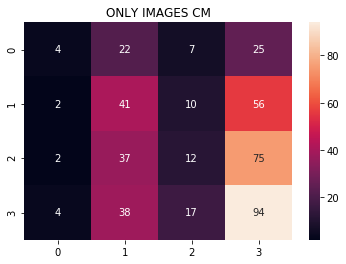

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

y_predict = model.predict_generator(test_generator, workers=-1)
y_predict_classes = y_predict.argmax(axis=-1)

cm = confusion_matrix(test_generator.classes, y_predict_classes)
sns.heatmap(cm, annot=True)
plt.title('ONLY IMAGES CM')
plt.show()

---
## Images and Data

In [29]:
"""
Create simple classifier and use after network
"""

main_input = Input(shape=(img_width, img_height, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=main_input)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

"""
Load Simple MLP
"""
aux_input = Input(shape=(features,))
aux = Dense(4096, activation='relu')(aux_input)
aux = Dense(4096, activation='relu')(aux)

# Merge input models
merge = concatenate([x, aux])
# interpretation
predictions = Dense(4, activation='softmax')(merge)

model = Model(inputs=[main_input, aux_input], outputs=predictions)
top_weights_path = 'models/multi_vgg16_top_model.h5'

for layer in base_model.layers:
    layer.trainable = False

opt = SGD(lr=0.00001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callback_list = [
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0),
    TensorBoard(log_dir=f'logs/multi_vgg16')
]

model.fit_generator(
    csv_train_generator,
    steps_per_epoch=1019 // batch_size,
    epochs=15,
    validation_data=csv_test_generator,
    validation_steps=446 // batch_size,
    callbacks=callback_list)

model.load_weights(top_weights_path)

Epoch 1/15
509/509 [==============================] - 185s 363ms/step - loss: 11.1623 - acc: 0.3075 - val_loss: 11.4646 - val_acc: 0.2870

Epoch 00001: val_acc improved from -inf to 0.28700, saving model to models/multi_vgg16_top_model.h5
Epoch 2/15
509/509 [==============================] - 194s 382ms/step - loss: 10.9565 - acc: 0.3202 - val_loss: 11.6022 - val_acc: 0.2803

Epoch 00002: val_acc did not improve
Epoch 3/15
509/509 [==============================] - 195s 383ms/step - loss: 10.9565 - acc: 0.3202 - val_loss: 11.3901 - val_acc: 0.2915

Epoch 00003: val_acc improved from 0.28700 to 0.29148, saving model to models/multi_vgg16_top_model.h5
Epoch 4/15
509/509 [==============================] - 197s 386ms/step - loss: 11.0515 - acc: 0.3143 - val_loss: 11.6467 - val_acc: 0.2758

Epoch 00004: val_acc did not improve
Epoch 5/15
509/509 [==============================] - 198s 389ms/step - loss: 11.0832 - acc: 0.3124 - val_loss: 11.6095 - val_acc: 0.2780

Epoch 00005: val_acc did not

In [30]:
"""
After training for a few epochs, freeze the bottom layers, and train only on top.
"""
for layer in model.layers[:vgg16_last_block_layer_number]:
    layer.trainable = False
for layer in model.layers[vgg16_last_block_layer_number:]:
    layer.trainable = True
    
opt = SGD(lr=0.00001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_weights_path = 'models/multi_vgg16_top_model.h5'

model.fit_generator(
    csv_train_generator,
    steps_per_epoch=1019 // batch_size,
    epochs=15,
    validation_data=csv_test_generator,
    validation_steps=446 // batch_size,
    callbacks=callback_list)

model.save(final_weights_path)

Epoch 1/15
509/509 [==============================] - 162s 319ms/step - loss: 10.9723 - acc: 0.3193 - val_loss: 11.2495 - val_acc: 0.3004

Epoch 00001: val_acc improved from 0.29821 to 0.30045, saving model to models/multi_vgg16_top_model.h5
Epoch 2/15
509/509 [==============================] - 175s 343ms/step - loss: 10.9090 - acc: 0.3232 - val_loss: 11.4360 - val_acc: 0.2892

Epoch 00002: val_acc did not improve
Epoch 3/15
509/509 [==============================] - 181s 357ms/step - loss: 11.2098 - acc: 0.3045 - val_loss: 11.5372 - val_acc: 0.2825

Epoch 00003: val_acc did not improve
Epoch 4/15
509/509 [==============================] - 183s 359ms/step - loss: 10.8299 - acc: 0.3281 - val_loss: 11.4275 - val_acc: 0.2892

Epoch 00004: val_acc did not improve
Epoch 5/15
509/509 [==============================] - 183s 359ms/step - loss: 11.1307 - acc: 0.3094 - val_loss: 11.6802 - val_acc: 0.2735

Epoch 00005: val_acc did not improve
Epoch 6/15
509/509 [==============================] - 

(446,)
(446,)


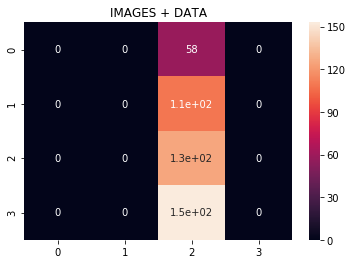

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_predict = model.predict_generator(csv_test_generator, steps=test_generator.n/2)
y_predict_classes = y_predict.argmax(axis=-1)

print(y_predict_classes.shape)
print(test_generator.classes.shape)
cm = confusion_matrix(test_generator.classes, y_predict_classes)
sns.heatmap(cm, annot=True)
plt.title('IMAGES + DATA')
plt.show()